<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/Prophet_Forecast_Prototype_19th_July.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]
!pip install --upgrade pandas-gbq

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

In [3]:
df.head()

,total_rows
0,14841792


### **Importing Libraries⏬**

In [ ]:
!pip install MiniSom
!pip install fbprophet

In [19]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import datetime as dt

from tqdm import tqdm
from minisom import MiniSom
from datetime import date
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from fbprophet import Prophet

sns.set()
%matplotlib inline

### **Downloading data from BQ**

In [6]:
%%bigquery --project machine-learning-msc df_train_novtojan --use_bqstorage_api

WITH kwhh AS (
SELECT  

ts,
ROUND(SUM(kwhh),3) AS tariff_sum,
COUNT(DISTINCT lcl_id) AS households_num,
ROUND(SUM(kwhh)/COUNT(DISTINCT lcl_id),3) AS tariff_avg

FROM `machine-learning-msc.forecasting_20200719.train_set` train

-- Only include data from November -> February
-- We'll use November -> January data to forecast February (28 days X 48 data points a day)
WHERE CAST(ts AS DATE) >= '2012-11-01' AND  CAST(ts AS DATE) < '2013-03-01'

GROUP BY 1
)

SELECT 
kwhh.*,
weather.* EXCEPT(ts, air_temperature),
LAST_VALUE(air_temperature IGNORE NULLS) OVER (ORDER BY weather.ts ASC) AS air_temperature
FROM kwhh
LEFT JOIN `machine-learning-msc.london_heathrow_hourly_weather_data.london_heathrow_hourly_weather` weather 
  ON TIMESTAMP_TRUNC(weather.ts, HOUR) = TIMESTAMP_TRUNC(kwhh.ts, hour)
  
ORDER BY kwhh.ts ASC

In [7]:
df_train_novtojan['tariff'] = df_train_novtojan['tariff_avg'] * np.max(df_train_novtojan['households_num'])
df_train_novtojan.head()

,ts,tariff_sum,households_num,tariff_avg,wind_speed,weather_flag,cloud_amount_flag,cloud_base_height,mean_sea_level_pressure,dewpoint,web_bulb_temperature,derived_hourly_sun_duration,air_temperature,tariff
0,2012-11-01 00:00:00+00:00,495.023,2680,0.185,16.0,81,8,60.0,978.0,8.3,10.1,0.0,11.8,495.985
1,2012-11-01 00:30:00+00:00,522.910,2680,0.195,16.0,81,8,60.0,978.0,8.3,10.1,0.0,11.8,522.795
2,2012-11-01 01:00:00+00:00,454.594,2680,0.170,11.0,62,7,30.0,977.4,7.8,8.3,0.0,8.8,455.770
3,2012-11-01 01:30:00+00:00,411.602,2680,0.154,11.0,62,7,30.0,977.4,7.8,8.3,0.0,8.8,412.874
4,2012-11-01 02:00:00+00:00,369.846,2676,0.138,11.0,61,8,100.0,976.9,7.7,8.1,0.0,8.5,369.978


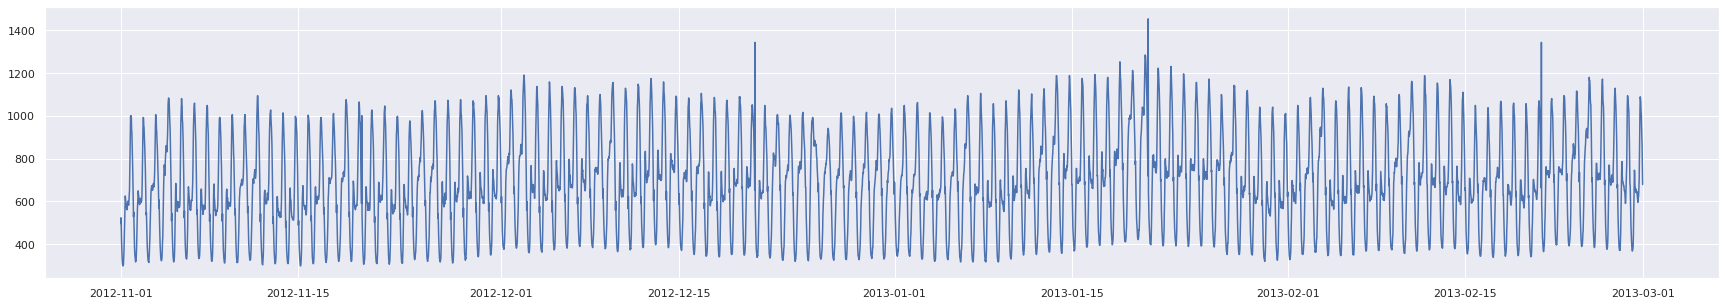

In [8]:
plt.figure(figsize=(30,5))
plt.plot(df_train_novtojan['ts'], df_train_novtojan['tariff'])

### **Quick prototype using FB Prophet - No External Regressors**


In [198]:
def get_training_period(df, date_filter):
    df['ds'] = df['ds'].dt.tz_localize(None) # remove timezones 
    df_out = df.query(f"ds < '{date_filter}'").copy()
    assert len(df_out) < len(df)
    assert df_out['ds'].max() < dt.datetime.strptime(date_filter, "%Y-%m-%d")
    return df_out

df = df_train_novtojan[['ts','tariff_avg']].copy()
df.rename(columns={"ts":"ds", "tariff_avg":"y"}, inplace=True)
df_train = get_training_period(df, "2013-02-01")
df_train.head()

,ds,y
0,2012-11-01 00:00:00,0.185
1,2012-11-01 00:30:00,0.195
2,2012-11-01 01:00:00,0.170
3,2012-11-01 01:30:00,0.154
4,2012-11-01 02:00:00,0.138


In [199]:
custom_hols = pd.DataFrame({
  'holiday': 'December Year End',
  'ds': pd.to_datetime(['2012-12-20', '2012-12-21', '2012-12-22',
                        '2012-12-23', '2012-12-24', '2012-12-25',
                        '2012-12-26', '2012-12-27', '2012-12-28',
                        '2012-12-29', '2012-12-30', '2012-12-31',
                        '2013-01-01', '2013-01-02', '2013-01-03']),
  'lower_window': 0,
  'upper_window': 1,
})

In [200]:
m = Prophet(holidays=custom_hols, seasonality_mode='additive')
m.add_country_holidays(country_name='UK')
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [201]:
future = m.make_future_dataframe(periods=1440, freq='30min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5851,2013-03-02 21:30:00,0.302439,0.198681,0.396403
5852,2013-03-02 22:00:00,0.279347,0.175651,0.374956
5853,2013-03-02 22:30:00,0.256398,0.158141,0.348760
5854,2013-03-02 23:00:00,0.234633,0.133984,0.331465
5855,2013-03-02 23:30:00,0.214454,0.111867,0.309632


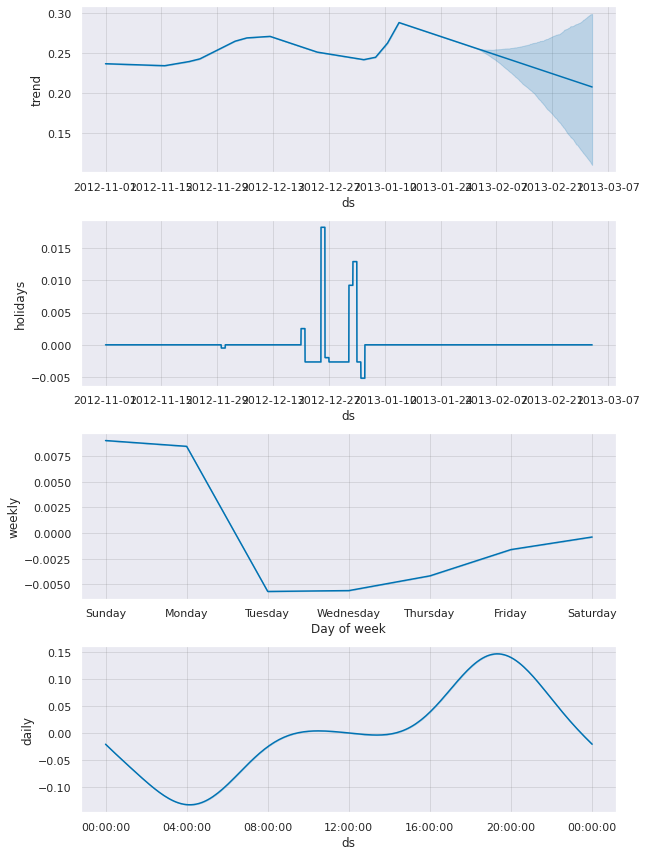

In [202]:
fig = m.plot_components(forecast)

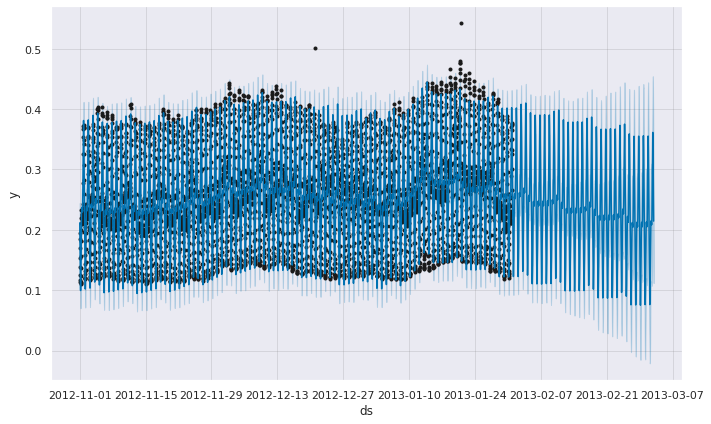

In [204]:
plt = m.plot(forecast)

### **Quick prototype using FB Prophet - With Temperature as Additive External Regressor 🌡**


In [205]:
def get_training_period(df, date_filter):
    df['ds'] = df['ds'].dt.tz_localize(None) # remove timezones 
    df_out = df.query(f"ds < '{date_filter}'").copy()
    assert len(df_out) < len(df)
    assert df_out['ds'].max() < dt.datetime.strptime(date_filter, "%Y-%m-%d")
    return df_out

df = df_train_novtojan[['ts','tariff_avg', 'air_temperature']].copy()
df.rename(columns={"ts":"ds", "tariff_avg":"y"}, inplace=True)
df_train = get_training_period(df, "2013-02-01")
df_train.head()

,ds,y,air_temperature
0,2012-11-01 00:00:00,0.185,11.8
1,2012-11-01 00:30:00,0.195,11.8
2,2012-11-01 01:00:00,0.170,8.8
3,2012-11-01 01:30:00,0.154,8.8
4,2012-11-01 02:00:00,0.138,8.5


In [206]:
custom_hols = pd.DataFrame({
  'holiday': 'December Year End',
  'ds': pd.to_datetime(['2012-12-20', '2012-12-21', '2012-12-22',
                        '2012-12-23', '2012-12-24', '2012-12-25',
                        '2012-12-26', '2012-12-27', '2012-12-28',
                        '2012-12-29', '2012-12-30', '2012-12-31',
                        '2013-01-01', '2013-01-02', '2013-01-03']),
  'lower_window': 0,
  'upper_window': 1,
})

m_temp = Prophet(holidays=custom_hols, seasonality_mode='additive')
m_temp.add_country_holidays(country_name='UK')
m_temp.add_regressor('air_temperature')
m_temp.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [207]:
def create_future_df(prophet_model, periods=1440, freq='30min', ext_regressor=None, df=None):
    future_df = prophet_model.make_future_dataframe(periods=periods, freq=freq)
    if ext_regressor != None:
        assert type(df) == pd.core.frame.DataFrame
        df['ds'] = df['ds'].dt.tz_localize(None) # remove timezones 
        addn_cols = [ext_regressor] if type(ext_regressor) == str else ext_regressor
        assert type(addn_cols) == list 
        future_df = future_df.merge(df[['ds'] + addn_cols], left_on='ds', right_on='ds')
    return future_df

future_temp = create_future_df(m_temp, ext_regressor='air_temperature', df=df)
forecast_temp = m_temp.predict(future_temp)
forecast_temp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5755,2013-02-28 21:30:00,0.350988,0.311515,0.383641
5756,2013-02-28 22:00:00,0.328873,0.288426,0.364531
5757,2013-02-28 22:30:00,0.305476,0.268107,0.341557
5758,2013-02-28 23:00:00,0.285419,0.249107,0.321660
5759,2013-02-28 23:30:00,0.264721,0.227263,0.300306


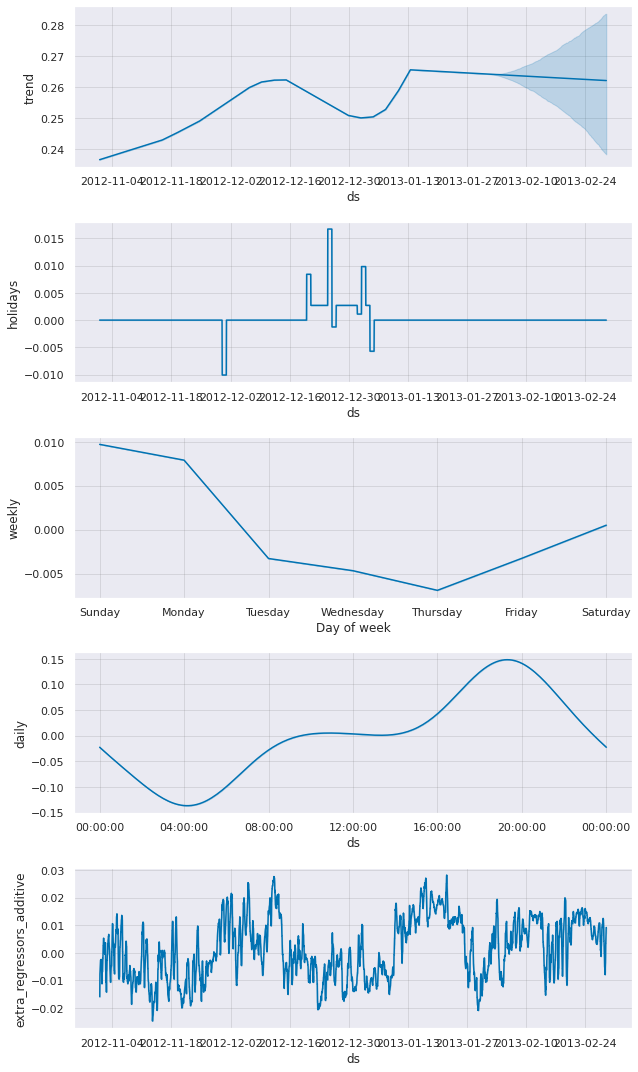

In [208]:
fig_temp = m_temp.plot_components(forecast_temp)

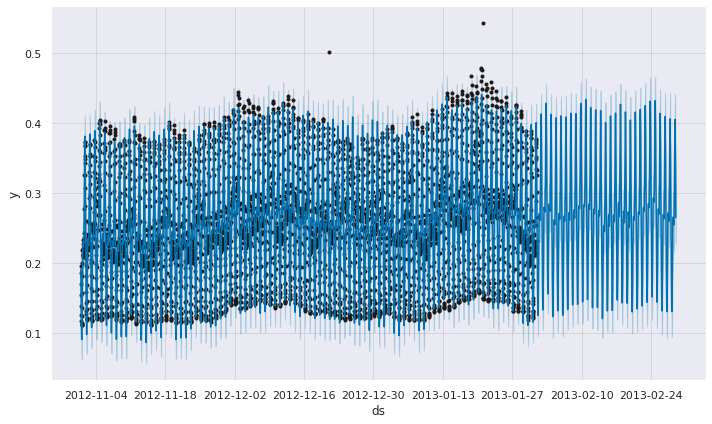

In [209]:
tmpplot = m_temp.plot(forecast_temp)

### **Quick prototype using FB Prophet - With Temperature as Multiplicative External Regressor 🌡**


In [210]:
m_temp_mul = Prophet(holidays=custom_hols, seasonality_mode='multiplicative')
m_temp_mul.add_country_holidays(country_name='UK')
m_temp_mul.add_regressor('air_temperature', mode='multiplicative')
m_temp_mul.fit(df_train)

future_temp_mul = create_future_df(m_temp_mul, ext_regressor='air_temperature', df=df)
forecast_temp_mul = m_temp_mul.predict(future_temp_mul)
forecast_temp_mul[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
5755,2013-02-28 21:30:00,0.342318,0.280909,0.396326
5756,2013-02-28 22:00:00,0.320056,0.256301,0.371982
5757,2013-02-28 22:30:00,0.296598,0.238127,0.343876
5758,2013-02-28 23:00:00,0.276345,0.225142,0.324434
5759,2013-02-28 23:30:00,0.255599,0.204387,0.301043


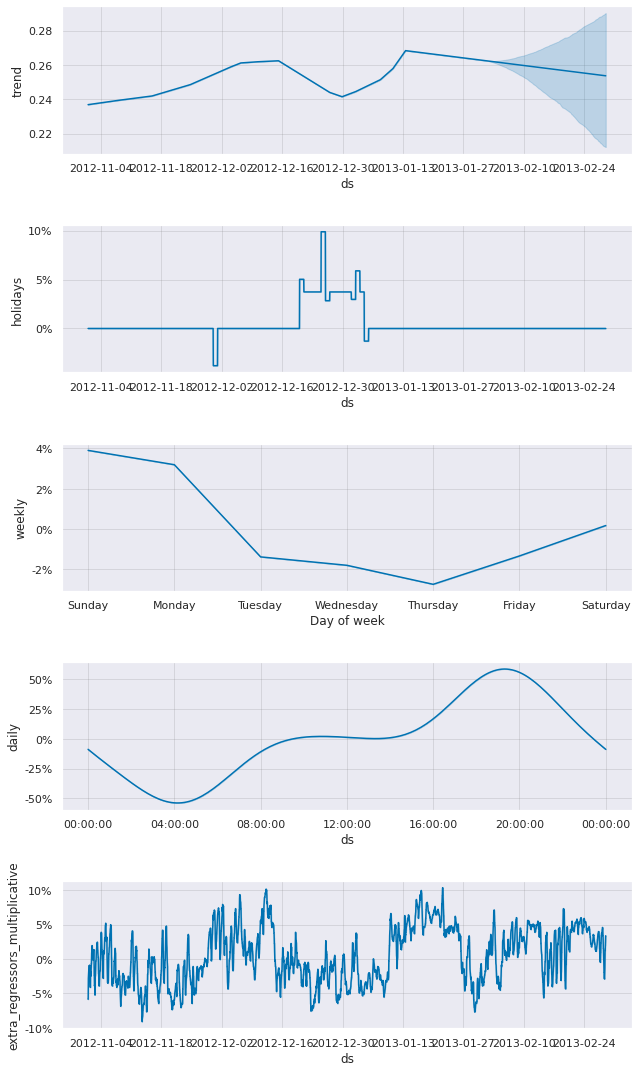

In [211]:
fig_temp_mul = m_temp_mul.plot_components(forecast_temp_mul)

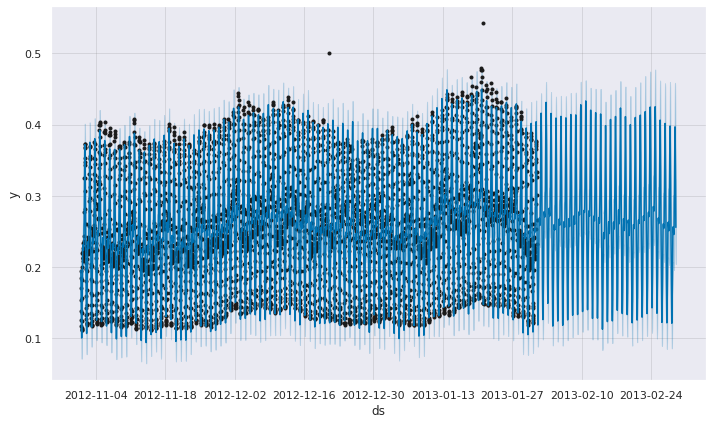

In [213]:
fig_fc_temp_mul = m_temp_mul.plot(forecast_temp_mul)

### **Quick prototype using FB Prophet - With more weather data as Add External Regressor 🌡**


In [215]:
def get_training_period(df, date_filter):
    df['ds'] = df['ds'].dt.tz_localize(None) # remove timezones 
    df_out = df.query(f"ds < '{date_filter}'").copy()
    assert len(df_out) < len(df)
    assert df_out['ds'].max() < dt.datetime.strptime(date_filter, "%Y-%m-%d")
    return df_out

df = df_train_novtojan[['ts','tariff_avg', 'air_temperature', 'wind_speed', 'mean_sea_level_pressure']].copy()
df.rename(columns={"ts":"ds", "tariff_avg":"y"}, inplace=True)
df_train = get_training_period(df, "2013-02-01")
df_train.head()

,ds,y,air_temperature,wind_speed,mean_sea_level_pressure
0,2012-11-01 00:00:00,0.185,11.8,16.0,978.0
1,2012-11-01 00:30:00,0.195,11.8,16.0,978.0
2,2012-11-01 01:00:00,0.170,8.8,11.0,977.4
3,2012-11-01 01:30:00,0.154,8.8,11.0,977.4
4,2012-11-01 02:00:00,0.138,8.5,11.0,976.9


In [217]:
m_weather = Prophet(holidays=custom_hols, seasonality_mode='additive')
m_weather.add_country_holidays(country_name='UK')
m_weather.add_regressor('air_temperature', mode='additive')
m_weather.add_regressor('wind_speed', mode='additive')
m_weather.add_regressor('mean_sea_level_pressure', mode='additive')
m_weather.fit(df_train)

ext_regressors = ['air_temperature', 'wind_speed', 'mean_sea_level_pressure']
future_weather = create_future_df(m_weather, ext_regressor=ext_regressors, df=df)
forecast_weather = m_weather.predict(future_weather)
forecast_weather[['ds', 'yhat'] + ext_regressors].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat,air_temperature,wind_speed,mean_sea_level_pressure
5755,2013-02-28 21:30:00,0.336912,0.006038,-0.000077,-0.006376
5756,2013-02-28 22:00:00,0.315185,0.007523,0.000359,-0.006510
5757,2013-02-28 22:30:00,0.291762,0.007523,0.000359,-0.006510
5758,2013-02-28 23:00:00,0.271786,0.009898,0.000359,-0.006577
5759,2013-02-28 23:30:00,0.251054,0.009898,0.000359,-0.006577


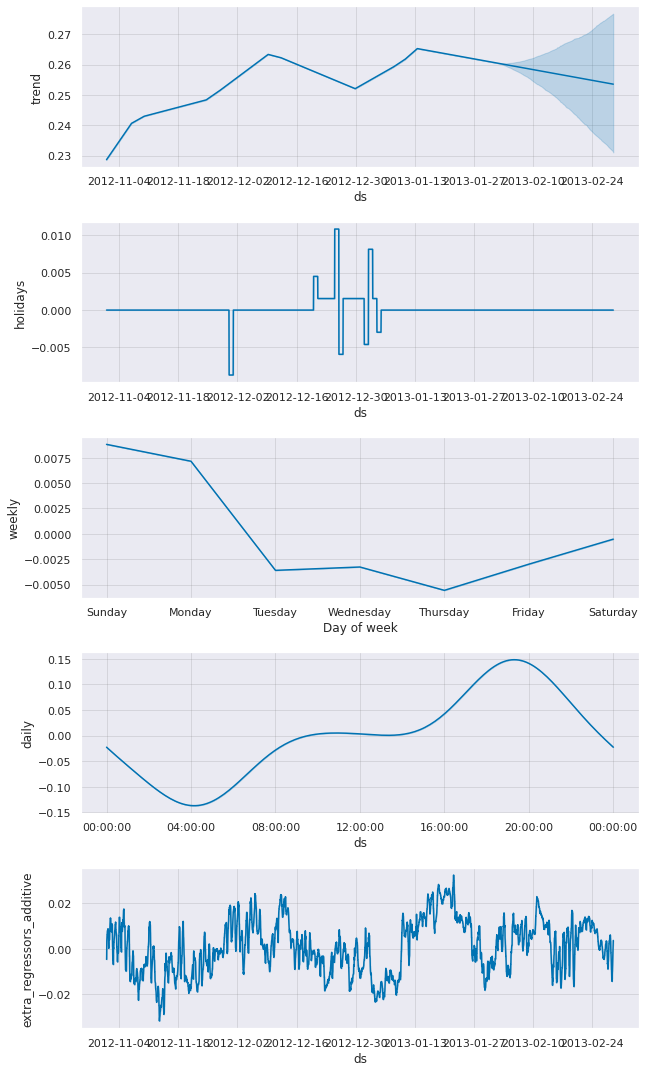

In [219]:
weathercomp = m_weather.plot_components(forecast_weather)

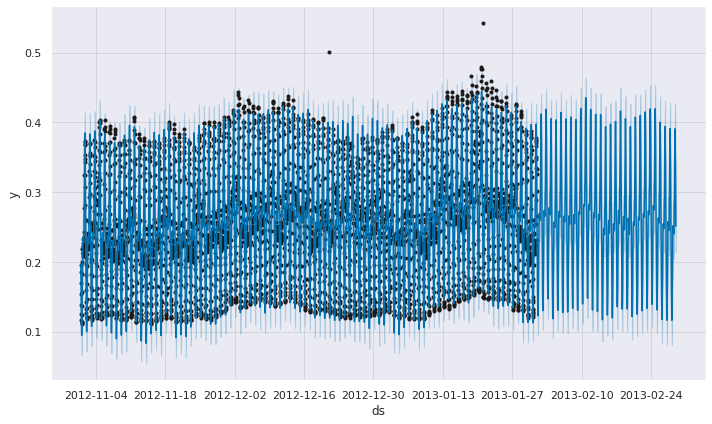

In [220]:
weatherfc = m_weather.plot(forecast_weather)

### **Quick prototype using FB Prophet - With more weather data as Multiplicative External Regressor 🌡**


In [225]:
m_weather_mul = Prophet(holidays=custom_hols, seasonality_mode='multiplicative')
m_weather_mul.add_country_holidays(country_name='UK')
m_weather_mul.add_regressor('air_temperature', mode='multiplicative')
m_weather_mul.add_regressor('wind_speed', mode='multiplicative')
m_weather_mul.add_regressor('mean_sea_level_pressure', mode='multiplicative')
m_weather_mul.fit(df_train)

ext_regressors = ['air_temperature', 'wind_speed', 'mean_sea_level_pressure']
future_weather_mul = create_future_df(m_weather_mul, ext_regressor=ext_regressors, df=df)
forecast_weather_mul = m_weather_mul.predict(future_weather_mul)
forecast_weather_mul[['ds', 'yhat'] + ext_regressors].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat,air_temperature,wind_speed,mean_sea_level_pressure
5755,2013-02-28 21:30:00,0.325518,0.021696,-0.000265,-0.024976
5756,2013-02-28 22:00:00,0.304302,0.027031,0.001235,-0.025499
5757,2013-02-28 22:30:00,0.281627,0.027031,0.001235,-0.025499
5758,2013-02-28 23:00:00,0.262087,0.035568,0.001235,-0.025760
5759,2013-02-28 23:30:00,0.242028,0.035568,0.001235,-0.025760


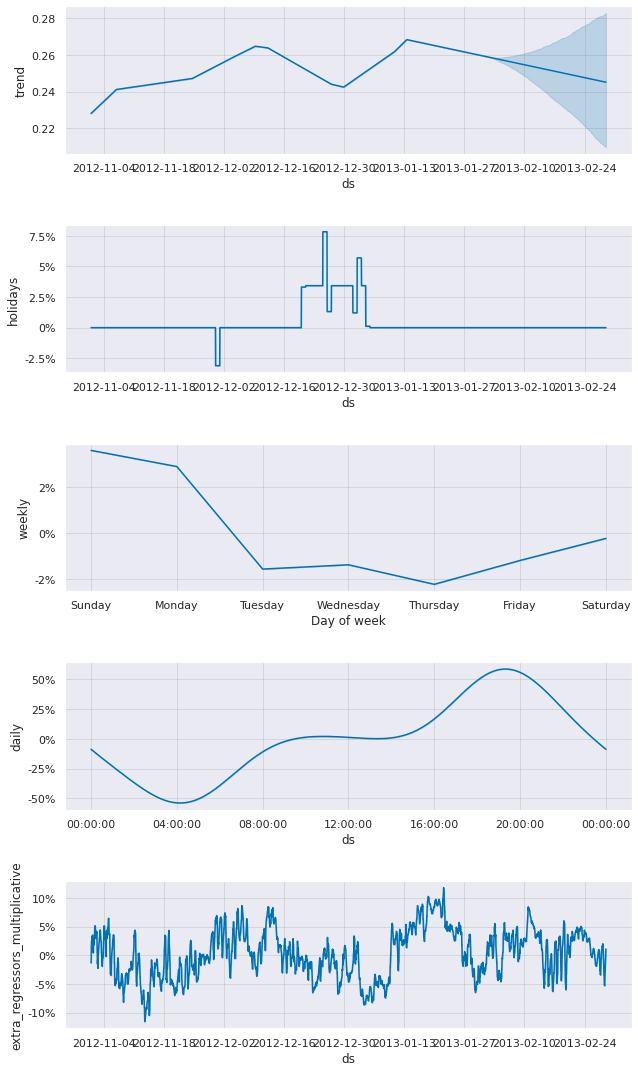

In [223]:
plt = m_weather_mul.plot_components(forecast_weather_mul)

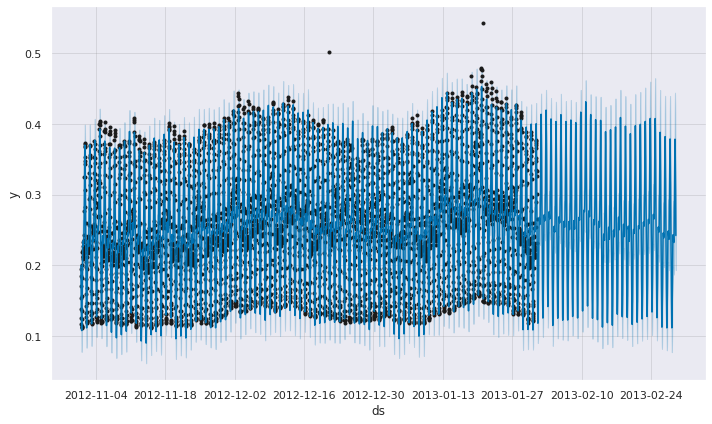

In [226]:
plt = m_weather_mul.plot(forecast_weather_mul)

### **Evaluating Forecasts**

In [227]:
def evaluate_mape(df, forecast_df, model_name):
    fc_start = '2013-02-01'
    y = df.query(f'ds>="{fc_start}"')[['ds','y']]
    pred = forecast_df.query(f'ds>="{fc_start}"')[['ds', 'yhat']]
    eval_df = y.merge(pred, on='ds')
    eval_df['abs_err'] = np.abs(eval_df['y'] - eval_df['yhat'])
    eval_df['abs_perc'] = np.round(eval_df['abs_err']/eval_df['y']*100,4)
    print(f"{model_name}, MAPE: {np.mean(eval_df['abs_perc'])}%")
    return np.mean(eval_df['abs_perc'])

In [228]:
eval_forecast_temp = evaluate_mape(df, forecast_temp, model_name="Temperature additive term")
eval_forecast_temp_mul = evaluate_mape(df, forecast_temp_mul, model_name="Temperature multiplicative term")
eval_forecast_weather = evaluate_mape(df, forecast_weather, model_name="Weather additive term")
eval_forecast_weather_mul = evaluate_mape(df, forecast_weather_mul, model_name="Weather multiplicative term")
eval_forecast = evaluate_mape(df, forecast, model_name="No external regressors")

Temperature additive term, MAPE: 8.10926428571427%
Temperature multiplicative term, MAPE: 7.460990104166683%
Weather additive term, MAPE: 7.325801562499999%
Weather multiplicative term, MAPE: 7.517048065476194%
No external regressors, MAPE: 12.986002678571424%


# **Evaluating Forecast models on test set**




### Preparing test set

In [167]:
%%bigquery --project machine-learning-msc df_test_raw --use_bqstorage_api

WITH kwhh AS (
SELECT  

ts,
ROUND(SUM(kwhh),3) AS tariff_sum,
COUNT(DISTINCT lcl_id) AS households_num,
ROUND(SUM(kwhh)/COUNT(DISTINCT lcl_id),3) AS tariff_avg

FROM `machine-learning-msc.forecasting_20200719.test_set` test

-- Only include data from November -> February
-- We'll use November -> January data to forecast February (28 days X 48 data points a day)
WHERE CAST(ts AS DATE) >= '2012-11-01' AND  CAST(ts AS DATE) < '2013-03-01'

GROUP BY 1
)

SELECT 
kwhh.*,
weather.* EXCEPT(ts, air_temperature),
LAST_VALUE(air_temperature IGNORE NULLS) OVER (ORDER BY weather.ts ASC) AS air_temperature
FROM kwhh
LEFT JOIN `machine-learning-msc.london_heathrow_hourly_weather_data.london_heathrow_hourly_weather` weather 
  ON TIMESTAMP_TRUNC(weather.ts, HOUR) = TIMESTAMP_TRUNC(kwhh.ts, hour)
  
ORDER BY kwhh.ts ASC

In [229]:
def prepare_df(df):
    df_out = df.copy()
    df_out = df_out[['ts', 'tariff_avg', 'wind_speed', 'air_temperature', 'mean_sea_level_pressure']]
    df_out['ts'] = df_out['ts'].dt.tz_localize(None) # remove timezones 
    df_out.rename(columns={'ts':'ds', 'tariff_avg': 'y'}, inplace=True)
    return df_out

In [230]:
df_test = prepare_df(df_test_raw)

In [231]:
forecast_test = m.predict(df_test)
forecast_temp_test = m_temp.predict(df_test)
forecast_temp_mul_test = m_temp_mul.predict(df_test)
forecast_weather_test = m_weather.predict(df_test)
forecast_weather_mul_test = m_weather_mul.predict(df_test)

In [232]:
eval_forecast_temp_test = evaluate_mape(df_test, forecast_temp_test, model_name="Temperature additive term test")
eval_forecast_temp_mul_test = evaluate_mape(df_test, forecast_temp_mul_test, model_name="Temperature multiplicative term test")
eval_forecast_weather_test = evaluate_mape(df_test, forecast_weather_test, model_name="Weather additive term")
eval_forecast_weather_mul_test = evaluate_mape(df_test, forecast_weather_mul_test, model_name="Weather multiplicative term test")
eval_forecast_test = evaluate_mape(df_test, forecast_test, model_name="No external regressors")

Temperature additive term test, MAPE: 8.519041443452377%
Temperature multiplicative term test, MAPE: 8.878245610119048%
Weather additive term, MAPE: 8.578561011904762%
Weather multiplicative term test, MAPE: 9.152805208333328%
No external regressors, MAPE: 14.613618526785714%
